No file 'logs/1-agents/heatmap-0.json'
No file 'logs/1-agents/heatmap-1.json'
No file 'logs/1-agents/heatmap-2.json'
No file 'logs/1-agents/heatmap-3.json'
No file 'logs/1-agents/heatmap-4.json'
No file 'logs/1-agents/heatmap-5.json'
No file 'logs/1-agents/heatmap-6.json'
No file 'logs/1-agents/heatmap-7.json'
No file 'logs/1-agents/heatmap-8.json'
No file 'logs/1-agents/heatmap-9.json'
No file 'logs/2-agents/heatmap-0.json'
No file 'logs/2-agents/heatmap-1.json'
No file 'logs/2-agents/heatmap-2.json'
No file 'logs/2-agents/heatmap-3.json'
No file 'logs/2-agents/heatmap-4.json'
No file 'logs/2-agents/heatmap-5.json'
No file 'logs/2-agents/heatmap-6.json'
No file 'logs/2-agents/heatmap-7.json'
No file 'logs/2-agents/heatmap-8.json'
No file 'logs/2-agents/heatmap-9.json'
No file 'logs/3-agents/heatmap-0.json'
No file 'logs/3-agents/heatmap-1.json'
No file 'logs/3-agents/heatmap-2.json'
No file 'logs/3-agents/heatmap-3.json'
No file 'logs/3-agents/heatmap-4.json'
No file 'logs/3-agents/he

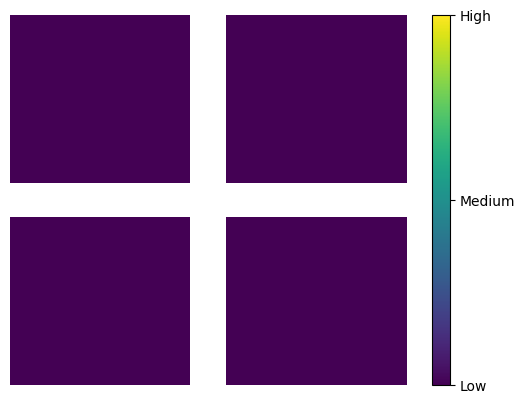

In [ ]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from lle import World

fig, axes = plt.subplots(2, 2)
world = World.from_file("maps/subgraph-1agents.toml")
for agent in range(1, 5):
    res = np.zeros((world.height, world.width), dtype=np.float32)
    filename = f"experiments/results/{agent}-agents/heatmap-{i}.json"

    try:
        with open(filename, "r") as f:
            heatmap = np.array(json.load(f))
        if res is None:
            res = heatmap
        else:
            res += heatmap
    except FileNotFoundError:
        print(f"No file '{filename}'")
    line = (agent -1)// 2
    col = (agent-1) % 2
    # Without x and y ticks
    axis: Axes = axes[line, col]
    axis = sns.heatmap(res, ax=axis, cbar=False, xticklabels=False, yticklabels=False, cmap="viridis")

cbar = fig.colorbar(None, ax=axes.ravel().tolist())
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(["Low", "Medium", "High"])

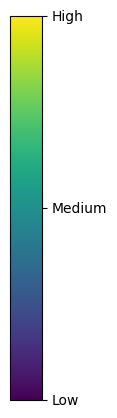

In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.85, 0.10, 0.05, 0.8])

cb = mpl.colorbar.ColorbarBase(ax, orientation="vertical", cmap="viridis", ticks=[0, 0.5, 1])
cb.set_ticks([0, 0.5, 1])  # Positions: start, middle, end of the colorbar
cb.set_ticklabels(["Low", "Medium", "High"])

plt.savefig("just_colorbar.svg", bbox_inches="tight")


In [1]:
from lle import LLE, WorldState, Action, World
from lle.exceptions import InvalidWorldStateError
import marlenv
import marl
import matplotlib.pyplot as plt
from marl.other.local_graph import LocalGraphTrainer, LocalGraphBottleneckFinder
import numpy as np
import networkx as nx

def state2array(state: WorldState, world: World) -> np.ndarray:
    array = state.as_array()
    array[0] = array[0] / world.height
    array[1] = array[1] / world.width
    return array


def state_hash(state: WorldState, world: World):
    arr_state = state2array(state, world)
    return hash(arr_state.data.tobytes())


In [2]:
env = LLE.from_file("maps/subgraph-1agent.toml").obs_type("layered").single_objective()
print(env.is_multi_objective)
world = env.world
# env = LLE.level(6).obs_type("state").single_objective()
masked_actions = np.full((1, 5), True)
masked_actions[0, Action.STAY.value] = False
env = marlenv.Builder(env).mask_actions(masked_actions).build()


qnetwork = marl.nn.model_bank.CNN.from_env(env)
policy = marl.policy.EpsilonGreedy.linear(1.0, 0.05, 100_000)
algo = marl.algo.DQN(qnetwork, policy, marl.policy.ArgMax())
dqn_trainer = marl.training.DQNTrainer(
    qnetwork,
    policy,
    marl.models.TransitionMemory(10_000),
    mixer=marl.algo.VDN.from_env(env),
    lr=1e-4,
    gamma=0.95,
    train_interval=(100, "step"),
)

False


In [3]:
from collections import defaultdict

def get_bottlenecks_stats(finder: LocalGraphBottleneckFinder):
    graph = nx.Graph()
    vertex_positions = dict()
    bottleneck_probs = dict[tuple[tuple[int, int],tuple[int, int]], float]()
    hit_count = defaultdict(int)
    apparition_counts = defaultdict(int)

    for i in range(world.height):
        for j in range(world.width):
            from_state = WorldState([(i, j)], [], [True])
            vertex_positions[from_state.agents_positions[0]] = (j, i)
            try:
                world.set_state(from_state)
                for action in world.available_joint_actions():
                    if action == [Action.STAY]:
                        continue
                    world.set_state(from_state)
                    world.step(action)
                    new_state = world.get_state()
                    edge = (state_hash(from_state, world), state_hash(new_state, world))

                    graph.add_edge(from_state.agents_positions[0], new_state.agents_positions[0])
                    hit_count[i, j] += finder.hit_count.get(edge, 0)
                    apparition_counts[i, j] += finder.apparition_count.get(edge, 0)
                    bottleneck_probability = finder.predict(edge)
                    if bottleneck_probability > 0:
                        bottleneck_probs[from_state.agents_positions[0], new_state.agents_positions[0]] = bottleneck_probability
            except InvalidWorldStateError:
                pass
    return graph, vertex_positions, bottleneck_probs

def show_bottlenecks(graph, vertex_positions: dict, bottleneck_probs: dict[tuple, float]):
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, pos=vertex_positions, label=False, node_size=100)
    nx.draw_networkx_edges(graph, pos=vertex_positions)
    nx.draw_networkx_edge_labels(graph, pos=vertex_positions, edge_labels={k: f"{v:.3f}" for k, v in bottleneck_probs.items()})
    #plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("bottlenecks.svg")
    plt.show()

In [4]:
bottlenecks = dict[tuple, list[float]]()
N_EXPERIMENTS = 10
for seed in range(N_EXPERIMENTS):
    finder = LocalGraphBottleneckFinder()
    trainer = LocalGraphTrainer(finder, world, None)
    exp = marl.Experiment.create(logdir="logs/test", trainer=trainer, n_steps=100_000, test_interval=0, env=env)
    print(f"Experiment {seed + 1}/{N_EXPERIMENTS}")
    exp.run(seed)
    graph, vertex_positions, bottleneck_probs = get_bottlenecks_stats(finder)
    for edge, prob in bottleneck_probs.items():
        if edge not in bottlenecks:
            bottlenecks[edge] = []
        bottlenecks[edge].append(prob)
    #show_bottlenecks(graph, vertex_positions, bottleneck_probs, hit_count, apparition_counts)

total_bottleneck_probs = dict()
for edge, probs in bottlenecks.items():
    total_bottleneck_probs[edge] = np.mean(probs)
    print(edge, len(probs), np.mean(probs), np.std(probs))

show_bottlenecks(graph, vertex_positions, total_bottleneck_probs)

Experiment 1/10


Training:   2%|▏         | 2144/100000 [00:00<00:07, 13057.05Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 100000/100000 [00:04<00:00, 22987.22Step/s]


Experiment 2/10


Training:   2%|▏         | 2333/100000 [00:00<00:05, 17189.35Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 100000/100000 [00:04<00:00, 22854.38Step/s]


Experiment 3/10


Training:   2%|▏         | 1810/100000 [00:00<00:07, 13195.69Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 100000/100000 [00:04<00:00, 23663.28Step/s]


Experiment 4/10


Training:   1%|          | 733/100000 [00:00<00:17, 5806.87Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 100000/100000 [00:04<00:00, 22209.07Step/s]


Experiment 5/10


Training:   3%|▎         | 2746/100000 [00:00<00:05, 17195.34Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 100000/100000 [00:04<00:00, 22518.72Step/s]


Experiment 6/10


Training:   3%|▎         | 2755/100000 [00:00<00:05, 16446.17Step/s]

        0 Average score: 2.0


Training: 100%|██████████| 100000/100000 [00:04<00:00, 21744.88Step/s]


Experiment 7/10


Training:   1%|          | 1244/100000 [00:00<00:07, 12367.53Step/s]

        0 Average score: 2.0


Training: 100%|█████████▉| 99537/100000 [00:04<00:00, 23841.40Step/s]

NetworkXError: Graph has no nodes or edges

Training: 100%|█████████▉| 99999/100000 [00:23<00:00, 23841.40Step/s]

In [ ]:
import json
total_bottleneck_probs = dict()
for edge, probs in bottlenecks.items():
    total_bottleneck_probs[edge] = float(np.mean(probs))

print(total_bottleneck_probs)
with open("bottlenecks.json", "w") as f:
    json_data = {str(k): v for k, v in total_bottleneck_probs.items()}
    json.dump(json_data, f)

show_bottlenecks(graph, vertex_positions, total_bottleneck_probs)


In [ ]:
import seaborn as sns
heatmap = np.zeros((world.height, world.width))
for edge, prob in total_bottleneck_probs.items():
    start, end = edge
    heatmap[start] += prob
    heatmap[end] += prob

plt.figure(figsize=(10.5, 5.5))
sns.heatmap(heatmap)
# plt.savefig("heatmap.svg")

plt.show()

In [7]:
env = LLE.from_file("maps/subgraph-2agents.toml").obs_type("layered").single_objective()
masked_actions = np.full((2, 5), True)
masked_actions[:, Action.STAY.value] = False
env = marlenv.Builder(env).mask_actions(masked_actions).build()

finder = LocalGraphBottleneckFinder()
trainer = LocalGraphTrainer(finder)
exp = marl.Experiment.create(logdir="logs/2-agents", trainer=trainer, n_steps=1_000_000, test_interval=0, env=env)
exp.run()

thread '<unnamed>' panicked at src/core/world/world.rs:526:67:
called `Result::unwrap()` on an `Err` value: NoAgents


PanicException: called `Result::unwrap()` on an `Err` value: NoAgents